<a href="https://colab.research.google.com/github/Hmyrova/-9/blob/main/%D0%A5%D0%BC%D1%8B%D1%80%D0%BE%D0%B2%D0%B0_%D0%90%D0%BD%D0%B0%D1%81%D1%82%D0%B0%D1%81%D0%B8%D1%8F_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
# Функция загрузки данных Bitcoin
def get_bitcoin_data():
    bitcoin = yf.Ticker("BTC-USD")
    df = bitcoin.history(period="7d", interval="1m")  # Данные за 7 дней с шагом 1 минута
    df.reset_index(inplace=True)

    # Добавляем временные признаки
    df["hour"] = df["Datetime"].dt.hour
    df["minute"] = df["Datetime"].dt.minute
    df["dayofweek"] = df["Datetime"].dt.dayofweek

    # Добавляем лаговые признаки
    df["Close_lag1"] = df["Close"].shift(1)
    df["Close_lag5"] = df["Close"].shift(5)
    df["Close_lag10"] = df["Close"].shift(10)

    return df.dropna()  # Убираем строки с NaN

# Загружаем и обрабатываем данные
data = get_bitcoin_data()
data.set_index('Datetime', inplace=True)

# Посмотрим на первые несколько строк данных
print(data.head())

                                   Open          High           Low  \
Datetime                                                              
2025-03-15 00:13:00+00:00  84182.257812  84182.257812  84182.257812   
2025-03-15 00:15:00+00:00  84171.656250  84171.656250  84171.656250   
2025-03-15 00:16:00+00:00  84169.734375  84169.734375  84169.734375   
2025-03-15 00:18:00+00:00  84198.781250  84198.781250  84198.781250   
2025-03-15 00:19:00+00:00  84208.921875  84208.921875  84208.921875   

                                  Close     Volume  Dividends  Stock Splits  \
Datetime                                                                      
2025-03-15 00:13:00+00:00  84182.257812  356294656        0.0           0.0   
2025-03-15 00:15:00+00:00  84171.656250          0        0.0           0.0   
2025-03-15 00:16:00+00:00  84169.734375   45293568        0.0           0.0   
2025-03-15 00:18:00+00:00  84198.781250          0        0.0           0.0   
2025-03-15 00:19:00+00:00  8

In [3]:
# Выбираем признаки и целевую переменную
features = ["Open", "High", "Low", "Volume", "hour", "minute", "dayofweek", "Close_lag1", "Close_lag5", "Close_lag10"]
target = "Close"

X = data[features]  # Признаки
y = data[target]    # Целевая переменная (цена закрытия)

# Разделяем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor(n_estimators=200, random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Проверим точность модели на тестовых данных
score = model.score(X_test, y_test)
print(f"Точность модели на тестовых данных: {score:.4f}")

Точность модели на тестовых данных: 1.0000


In [4]:
def predict_future_prices():
    global model, data, features

    # Прогнозируем цену на основе последней строки данных
    last_row = pd.DataFrame([data.iloc[-1][features]], columns=features)  # Последняя строка данных (текущая ситуация)

    # Множество интервалов прогнозирования (например, 10 минут)
    future_times = [10]  # В минутах

    prediction_results = []  # Список для хранения результатов прогнозирования

    for future_time in future_times:
        # Вычисляем будущее время, добавляя нужное количество минут
        future_index = data.index[-1] + pd.Timedelta(minutes=future_time)

        # Обновляем временные признаки для будущего времени
        last_row["hour"] = future_index.hour
        last_row["minute"] = future_index.minute
        last_row["dayofweek"] = future_index.dayofweek

        # Прогнозируем цену на будущее время
        predicted_price = model.predict(last_row)[0]
        prediction_results.append((future_index, predicted_price))
        print(f"Через {future_time} минут ({future_index}): {predicted_price:.5f} USD")

    return prediction_results

# Выполним прогноз
predictions = predict_future_prices()

Через 10 минут (2025-03-21 09:53:00+00:00): 84223.20141 USD


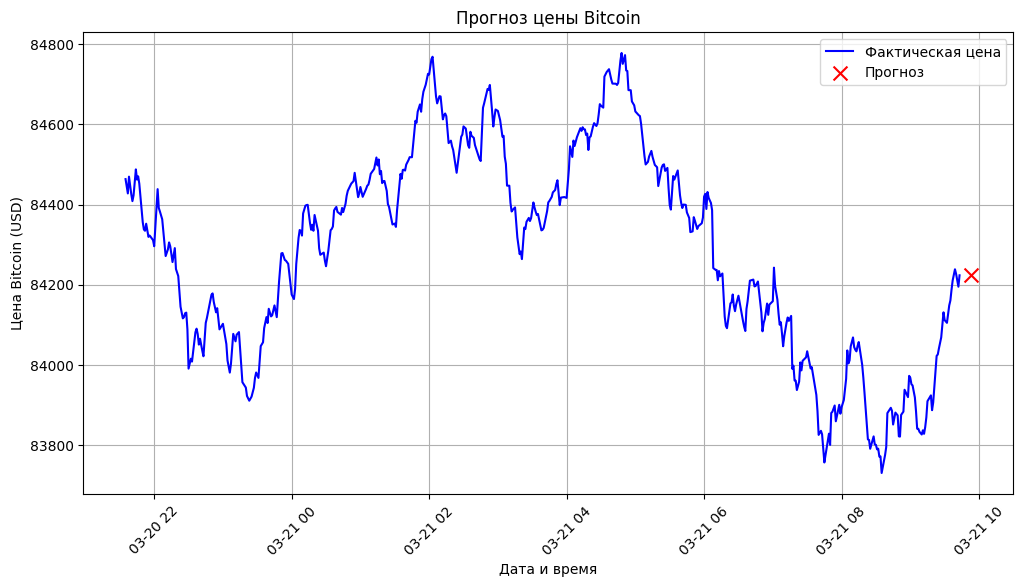

In [5]:
# Функция для построения графика фактических и прогнозируемых цен
def plot_predictions(data, prediction_results):
    plt.figure(figsize=(12, 6))

    # График фактических цен (последние 500 минут данных)
    plt.plot(data.index[-500:], data["Close"].tail(500), label="Фактическая цена", color="blue")

    # Предсказанные значения
    times, prices = zip(*prediction_results)
    plt.scatter(times, prices, color="red", label="Прогноз", marker="x", s=100)

    plt.xlabel("Дата и время")
    plt.ylabel("Цена Bitcoin (USD)")
    plt.title("Прогноз цены Bitcoin")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Построим график для фактических и предсказанных цен
plot_predictions(data, predictions)